# Importing Dependencies



In [1]:
import re
import numpy as np
import pandas as pd

import tweepy

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

## Importing Dataset

In [2]:
dataset_columns = ["sentiment" , "id" , "time" , "flag" , "user" , "text" ]
dataset_coding = "ISO-8859-1"
dataset = pd.read_csv("data set/training.1600000.processed.noemoticon.csv", names = dataset_columns , encoding = dataset_coding )

In [3]:
dataset.head()

,sentiment,id,time,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
print("Dataset size:", len(dataset))

Dataset size: 1600000


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   time       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
dataset["sentiment"].unique()

array([0, 4])

In [7]:
dataset["sentiment"].nunique()

2

In [8]:
dataset["sentiment"].value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [9]:
dataset.isnull().sum()

sentiment    0
id           0
time         0
flag         0
user         0
text         0
dtype: int64

## Preprocessing / Cleaning Text

In [10]:
nltk.download('stopwords')
all_stopwords = stopwords.words('english')


[nltk_data] Downloading package stopwords to /home/alpha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess(tweet , stem = True):
    processedText = []
    
    urlPattern =  r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphanumericPattern = r'\w*\d\w*'
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    punc = r'[^\w\s]'
    
    #tweet = tweet.lower()
    tweet = re.sub(urlPattern , '' , tweet)
    tweet = re.sub(userPattern , '' , tweet)
    tweet = re.sub(alphanumericPattern , '' , tweet)
    tweet = re.sub(sequencePattern , seqReplacePattern , tweet)
    tweet = re.sub(punc,"",tweet)
    
    tweet = tweet.split()   
    ps = PorterStemmer()
    
    all_stopwords = stopwords.words('english')
  
    
    for word in tweet:
            if word not in (all_stopwords):
                if stem:
                    processedText.append(ps.stem(word))
                else:
                    processedText.append(word)
                
    return " ".join(processedText)
    
        
   

      

In [12]:
cleared_dataset = dataset.sample(frac=1).reset_index(drop=True)
cleared_dataset = cleared_dataset.iloc[0:1000000]
cleared_dataset.info()
cleared_dataset["sentiment"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1000000 non-null  int64 
 1   id         1000000 non-null  int64 
 2   time       1000000 non-null  object
 3   flag       1000000 non-null  object
 4   user       1000000 non-null  object
 5   text       1000000 non-null  object
dtypes: int64(2), object(4)
memory usage: 45.8+ MB


4    500029
0    499971
Name: sentiment, dtype: int64

In [13]:
import time
start_time = time.time()
cleared_dataset = cleared_dataset.drop(cleared_dataset.index[0]).reset_index()
cleared_dataset = cleared_dataset.drop(['time','flag','user','id','index'],axis=1)
cleared_dataset["text"] = cleared_dataset["text"].apply(preprocess)
print("--- %s seconds ---" % (time.time() - start_time))
X = cleared_dataset['text']
print(X)

--- 310.84272742271423 seconds ---
0         figur next move relax amp enjoy bit time daili...
1                                         use ebuck buy sim
2         the horni stalker kind take give noth return I...
3                                  I lost littl mount r key
4                                                  have fun
                                ...                        
999994    also dread today plate not full work done I fi...
999995                haha No problem I enjoy breviti relev
999996    met the cutest guy ever plu he age Ok I admit ...
999997                                want someon make cake
999998                     wish could go see amp play tonit
Name: text, Length: 999999, dtype: object


In [14]:
cleared_dataset

,sentiment,text
0,4,figur next move relax amp enjoy bit time daili...
1,4,use ebuck buy sim
2,0,the horni stalker kind take give noth return I...
3,0,I lost littl mount r key
4,4,have fun
...,...,...
999994,0,also dread today plate not full work done I fi...
999995,4,haha No problem I enjoy breviti relev
999996,0,met the cutest guy ever plu he age Ok I admit ...
999997,0,want someon make cake


## Analysing Data

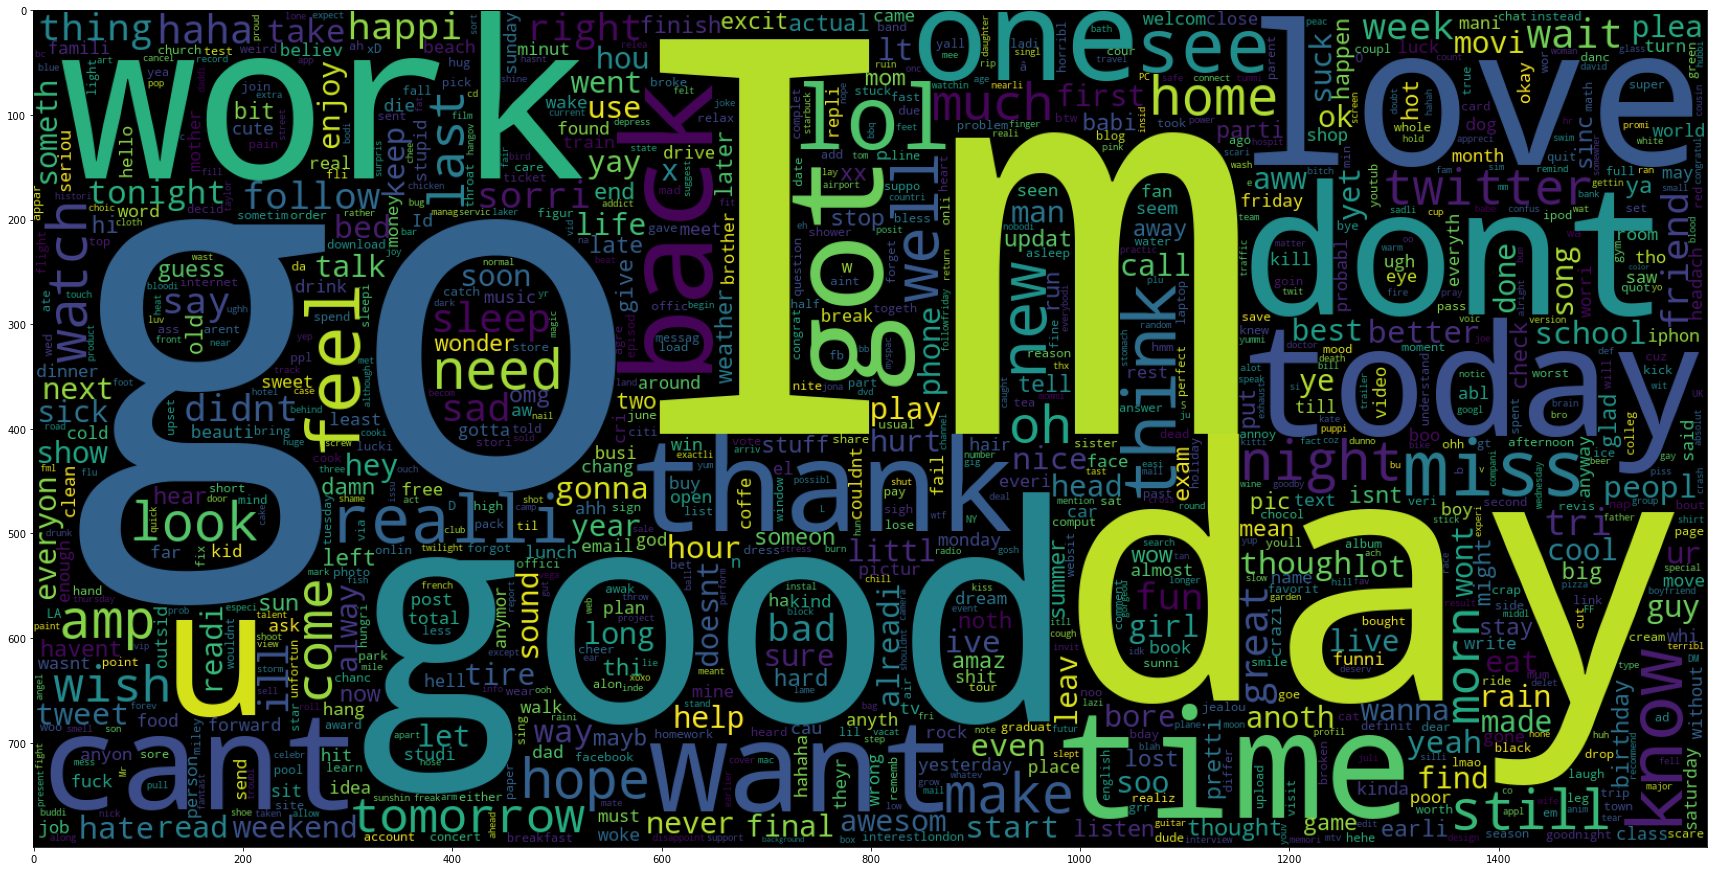

In [15]:
positive_tweet = cleared_dataset["text"][800000:]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, positive_tweet)))
plt.imshow(wc)

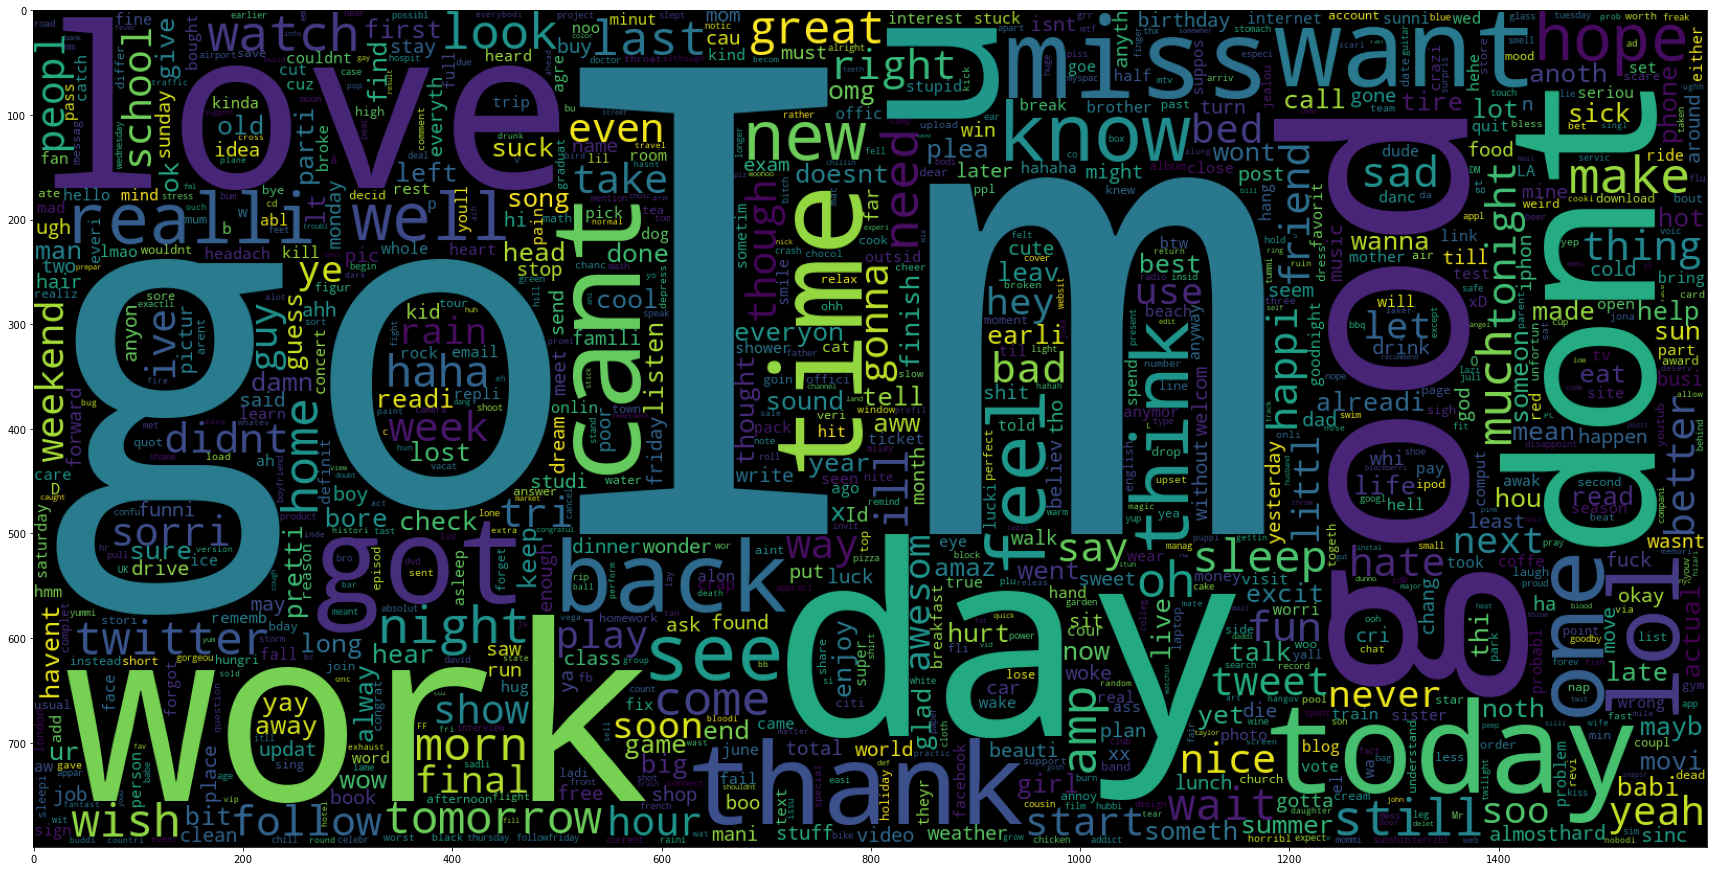

In [16]:
negative_tweet = cleared_dataset["text"][:800000]
plt.figure(figsize = (30,30))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(",".join(map(str, negative_tweet)))
plt.imshow(wc)

## Splitting Dataset

In [17]:
y = cleared_dataset['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.30, random_state = 10)

## TF - IDF Vectorizer

In [18]:
vectorizer = TfidfVectorizer(analyzer='word',max_df=0.90, min_df=2, max_features = 500000,ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
tfidf_tokens = vectorizer.get_feature_names()
print("Number of feature_words = ", len(tfidf_tokens))
print(tfidf_tokens[1:2000])


Number of feature_words =  474271
['__ __', '__ amp', '__ but', '__ friend', '__ get', '__ haha', '__ hope', '__ ill', '__ im', '__ like', '__ oh', '__ take', '__ wish', '__lt', '__quot', '__x', '_bam_', '_d', '_gt', '_i_', '_i_ want', '_let', '_love_', '_lt', '_quot', '_really_', '_those_', '_very_', '_whi', '_why_', 'aa', 'aa batteri', 'aa cannot', 'aa cant', 'aa dont', 'aa gaya', 'aa get', 'aa hate', 'aa im', 'aa lot', 'aa love', 'aa man', 'aa mau', 'aa meet', 'aa miss', 'aa number', 'aa one', 'aa twitter', 'aa work', 'aa xd', 'aaa', 'aaa im', 'aaa miss', 'aaaaaaalcohol', 'aaagh', 'aaah', 'aaah cant', 'aaah im', 'aaah need', 'aaah well', 'aaahh', 'aaahh im', 'aaahh man', 'aaalcohol', 'aaall', 'aaand', 'aaand back', 'aaand im', 'aaannd', 'aaargh', 'aaarghh', 'aaarh', 'aaarrggh', 'aaarrgghh', 'aaarrgh', 'aaaw', 'aaaw dont', 'aaaww', 'aac', 'aach', 'aachen', 'aackk', 'aaden', 'aaf', 'aag', 'aag ago', 'aagain', 'aaggeess', 'aaggess', 'aaggh', 'aagghh', 'aagh', 'aah', 'aah awesom', 'aah 

In [19]:
X_test  = vectorizer.transform(X_test)

## Scaling

In [20]:
x_max = X_train.max()
x_min = X_train.min()

X_train = (X_train - x_min)/x_max
X_test = (X_test - x_min)/x_max


## Model Evaluation

In [21]:

def model(model):
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred = y_pred.values 
    y_test_ = pd.Series(y_test) 
    y_test_ = y_test_.values 
    #print("Comparison:")
    #result = np.concatenate((y_pred.reshape(len(y_pred),1), y_test_.reshape(len(y_test_),1)),1)
    #print(result[1:500])
    
    c_matrix = confusion_matrix(y_test_, y_pred)
    print("Confusion Matrix = \n",c_matrix)
    print("Accuracy Score = ",accuracy_score(y_test_, y_pred))
    print("Train Score = ",model.score(X_train, y_train))
    print("Test Score = ",model.score(X_test, y_test))
    
    
    
    categories = ['Negative','Positive']
    prediction = ['True Negative','False Positive', 'False Negative','True Positive']
    percentage = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

    labels = [f'{m}\n{n}' for m, n in zip(prediction,percentage)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix,cmap = 'Blues' , fmt = '',annot = labels, xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.title ("Confusion Matrix")
    
    

## Logistic Regression

Confusion Matrix = 
 [[117544  32061]
 [ 28946 121449]]
Accuracy Score =  0.7966433333333334
Train Score =  0.8671926674180963
Test Score =  0.7966433333333334
--- 20.978049755096436 seconds ---


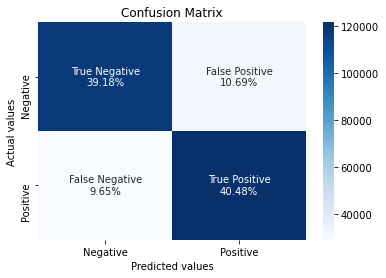

In [22]:
import time
start_time = time.time()
logistic_reg = LogisticRegression(solver = 'sag',C = 2, max_iter = 1500)
logistic_reg.fit(X_train, y_train) 
model(logistic_reg)
print("--- %s seconds ---" % (time.time() - start_time))

## Bernoulli Naive Bayes 

Confusion Matrix = 
 [[112948  36657]
 [ 28965 121430]]
Accuracy Score =  0.78126
Train Score =  0.8465854951221359
Test Score =  0.78126
--- 0.9526002407073975 seconds ---


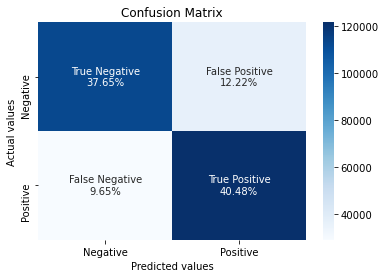

In [23]:
start_time = time.time()
naive_bayes = BernoulliNB()
naive_bayes.fit(X_train, y_train) 
model(naive_bayes)
print("--- %s seconds ---" % (time.time() - start_time))

## SVM


Confusion Matrix = 
 [[116090  33515]
 [ 30663 119732]]
Accuracy Score =  0.7860733333333333
Train Score =  0.9174670249528928
Test Score =  0.7860733333333333


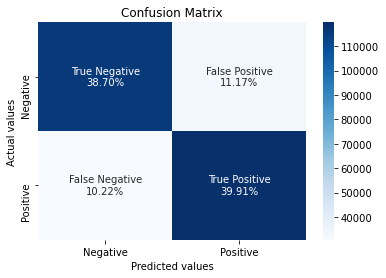

In [24]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV


svm = LinearSVC()
svm_model = CalibratedClassifierCV(svm) 
svm_model.fit(X_train, y_train)
model(svm_model)

##scikit-learn provides (CalibratedClassifierCV) which can be used to solve this problem: it allows to add probability output 
##to LinearSVC or any other classifier which implements decision_function method:

### Predict {Sentiment,Time,Probability}

In [39]:
def predict(model,text):
    start_time = time.time()
    sentiment=0
    sentiment_prob=[[]]
    textdata = vectorizer.transform([preprocess(text)])
    sentiment = model.predict(textdata)
    sentiment_prob = model.predict_proba(textdata)   
    prob = ('%.2f'%max(max(sentiment_prob*100)))
    timer = "%.2f seconds" % (time.time() - start_time)
    return sentiment[0],timer,prob      

### Sentiment Using API

In [42]:
#for tweet prediction by API
def tweets_of_twitter_user(user_name,no_of_tweets):
    config = pd.read_csv("config.csv")
    

    twitterApiKey = str(config['twitterApiKey'][0])
    twitterApiSecret = str(config['twitterApiSecret'][0])
    twitterApiAccessToken = str(config['twitterApiAccessToken'][0])
    twitterApiAccessTokenSecret = str(config['twitterApiAccessTokenSecret'][0])

    # Authenticate
    auth = tweepy.OAuthHandler(twitterApiKey, twitterApiSecret)
    auth.set_access_token(twitterApiAccessToken, twitterApiAccessTokenSecret)
    twetterApi = tweepy.API(auth, wait_on_rate_limit = True)


    twitterAccount = user_name

    tweets = tweepy.Cursor(twetterApi.user_timeline, 
                            screen_name=twitterAccount, 
                            count=None,
                            since_id=None,
                            max_id=None,
                            trim_user=True,
                            exclude_replies=True,
                            contributor_details=False,
                            include_entities=False
                            ).items(no_of_tweets);
    print(tweets)

    tweet_DataBase = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweet'])
    
    ### DataFrame for the sentiment of the user
    sentiment_score=[]
    for i in range(0,no_of_tweets):
        sentiment_score.append(0)
    
    for model in [logistic_reg,naive_bayes,svm_model]:
            prediction=[]
            i=0
            for tweets in tweet_DataBase["Tweet"]:
                sen,timer,prob=predict(tweets,model)
                
                prediction.append(float(prob))
                sentiment_score[i]=sentiment_score[i]+sen
                
                i+=1
            tweet_DataBase[model]=prediction
            
    sentiment_score=["Positive" if i>4 else "Negative" for i in sentiment_score]
    tweet_DataBase.columns=["Tweets","log_reg","naive","svm"]
    tweet_DataBase.insert(1,"Sentiment",sentiment_score,True)
    return tweet_DataBase

In [42]:
type(tweet_DataBase["naive"][0])

numpy.float64

In [58]:
tweet_DataBase["Sentiment"].value_counts()['Positive']

47

In [46]:
s=tweets_of_twitter_user("Boldsky",10)

In [47]:
type(s["svm"][0])

numpy.float64